In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
import ast
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
import seaborn as sns

In [5]:
df=pd.read_csv('Food_Delivery_Time_Prediction.csv')
df1=df.interpolate(method='linear',limit_direction='forward')
df1.head()

<ipython-input-5-8cdd1bf89d56>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df1=df.interpolate(method='linear',limit_direction='forward')


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [6]:
le = LabelEncoder()
df1["Traffic_Conditions"] = le.fit_transform(df["Traffic_Conditions"])
df1["Weather_Conditions"] = le.fit_transform(df["Weather_Conditions"])
df1["Order_Priority"] = le.fit_transform(df["Order_Priority"])
df1["Order_Time"] = le.fit_transform(df["Order_Time"])
df1["Vehicle_Type"] = le.fit_transform(df["Vehicle_Type"])

print(df1.head())

  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

   Weather_Conditions  Traffic_Conditions  Delivery_Person_Experience  \
0                   1                   2                           4   
1                   0                   2                           8   
2                   2                   2                           9   
3                   0                   1                           2   
4                   1                   0                           6   

   Order_Priority  Order_Time  Vehicle_Type  Restaurant_Rating  \
0               2           0             2                4.1

In [7]:
normalize_data=preprocessing.normalize(df1[['Distance','Delivery_Time',  'Order_Cost',  'Tip_Amount' ] ])
normalize_df=pd.DataFrame(normalize_data,columns=['Distance','Delivery_Time',  'Order_Cost',  'Tip_Amount'])
df_remaining=df1.drop(['Distance','Delivery_Time',  'Order_Cost',  'Tip_Amount' ],axis=1)
df2=pd.concat([df_remaining,normalize_df],axis=1)
df2.head()


,Order_ID,Customer_Location,Restaurant_Location,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Distance,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1,2,4,2,0,2,4.1,3.0,0.001186,0.019806,0.997904,0.061592
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0,2,8,1,3,2,4.5,4.2,0.126545,0.371623,0.903445,0.172249
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",2,2,9,0,3,1,3.3,3.4,0.004221,0.029416,0.998798,0.038977
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0,1,2,2,1,1,3.2,3.7,0.024693,0.199888,0.969179,0.141872
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",1,0,6,1,3,1,3.5,2.8,0.010827,0.052167,0.998573,0.003770


In [8]:
def haversine(Restaurant_Location,Customer_Location):
    R = 6371  # Earth’s radius in km
    lat1, lon1 = Restaurant_Location
    lat2, lon2 = Customer_Location
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [9]:
df2["Distance_between"] = df2.apply(lambda row: haversine(ast.literal_eval(row["Restaurant_Location"]), ast.literal_eval(row["Customer_Location"])), axis=1)


# Display results
print(df2[["Restaurant_Location", "Customer_Location", "Distance_between"]])

        Restaurant_Location       Customer_Location  Distance_between
0    (12.358515, 85.100083)  (17.030479, 79.743077)        775.651198
1    (14.174874, 77.025606)  (15.398319, 86.639122)       1042.385597
2    (19.594748, 82.048482)  (15.687342, 83.888808)        476.220706
3    (16.915906, 78.278698)  (20.415599, 78.046984)        389.912629
4    (15.206038, 86.203182)  (14.786904, 78.706532)        806.505886
..                      ...                     ...               ...
195  (18.098924, 87.896124)   (17.910045, 81.56199)        670.130652
196  (16.892341, 80.554716)   (21.66459, 82.226635)        558.891202
197  (13.625369, 82.418092)   (14.575401, 82.55641)        106.686689
198  (19.135509, 86.659978)  (12.094497, 82.893369)        880.580093
199   (20.941636, 77.01334)  (19.360304, 84.132424)        763.581776

[200 rows x 3 columns]


In [10]:
df["Delivery_Time"].describe()

,Delivery_Time
count,200.000000
mean,70.494950
std,29.830694
min,15.230000
25%,46.997500
50%,72.775000
75%,96.650000
max,119.670000


In [11]:
time_mapping = {
    2: 8,    # 5 AM - 12 PM
    0: 14, # 12 PM - 5 PM
    1: 18,   # 5 PM - 9 PM
    3: 22      # 9 PM - 5 AM
}

# Create a new column for estimated hour of order
df2['Hour_of_Day'] = df2['Order_Time'].map(time_mapping)

# Define rush hours (Example: 7-9 AM, 5-8 PM)
df2['Rush_Hour'] = df2['Hour_of_Day'].apply(lambda x: 1 if x in [22, 18] else 0)

# Display results
df2

,Order_ID,Customer_Location,Restaurant_Location,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Distance,Delivery_Time,Order_Cost,Tip_Amount,Distance_between,Hour_of_Day,Rush_Hour
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1,2,4,2,0,2,4.1,3.0,0.001186,0.019806,0.997904,0.061592,775.651198,14,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",0,2,8,1,3,2,4.5,4.2,0.126545,0.371623,0.903445,0.172249,1042.385597,22,1
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",2,2,9,0,3,1,3.3,3.4,0.004221,0.029416,0.998798,0.038977,476.220706,22,1
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0,1,2,2,1,1,3.2,3.7,0.024693,0.199888,0.969179,0.141872,389.912629,18,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",1,0,6,1,3,1,3.5,2.8,0.010827,0.052167,0.998573,0.003770,806.505886,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ORD0196,"(17.910045, 81.56199)","(18.098924, 87.896124)",0,0,8,2,3,1,4.7,4.0,0.016601,0.035118,0.998175,0.046234,670.130652,22,1
196,ORD0197,"(21.66459, 82.226635)","(16.892341, 80.554716)",2,2,8,1,3,0,3.0,3.6,0.003534,0.052544,0.998339,0.023371,558.891202,22,1
197,ORD0198,"(14.575401, 82.55641)","(13.625369, 82.418092)",2,0,4,2,0,1,2.9,3.4,0.015169,0.053874,0.998425,0.003754,106.686689,14,0
198,ORD0199,"(12.094497, 82.893369)","(19.135509, 86.659978)",1,0,9,1,3,2,3.9,4.8,0.065158,0.146078,0.959747,0.230871,880.580093,22,1


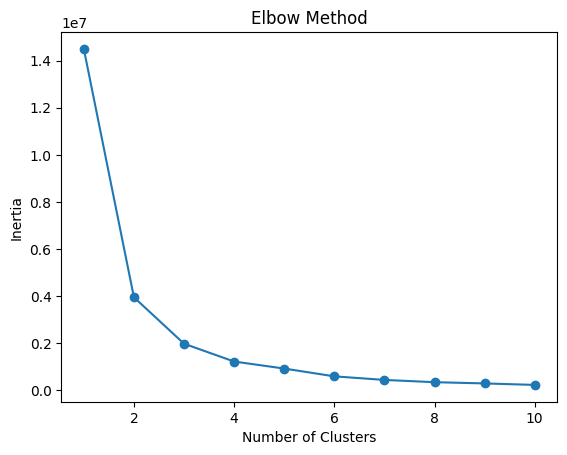

In [12]:
def extract_lat_lon(location_str):
    lat, lon = location_str.strip("()").split(", ")
    return float(lat), float(lon)

df2[['Cust_Lat', 'Cust_Lon']] = df2['Customer_Location'].apply(lambda x: pd.Series(extract_lat_lon(x)))
df2[['Rest_Lat', 'Rest_Lon']] = df2['Restaurant_Location'].apply(lambda x: pd.Series(extract_lat_lon(x)))
features= df2.drop(columns=['Order_ID', 'Customer_Location', 'Restaurant_Location']).columns
x = df2[features]


inertias=[]
for k in range(1,11):
    model=KMeans(n_clusters=k)
    model.fit(x)
    inertias.append(model.inertia_)
plt.plot(range(1,11),inertias,'-o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


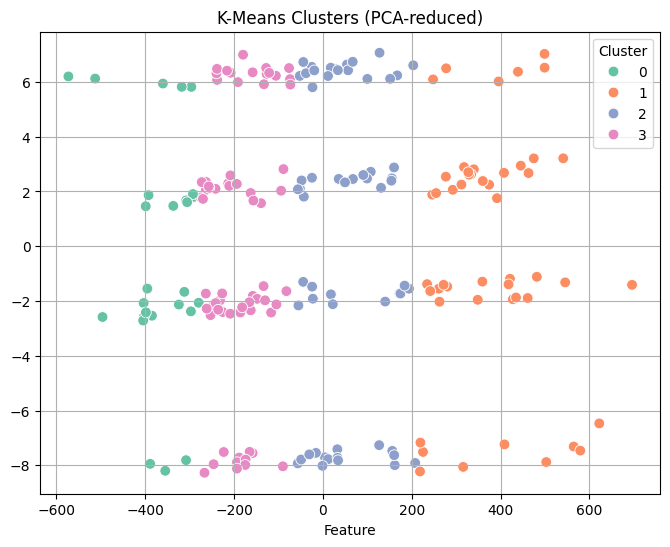

In [13]:
kmeans=KMeans(n_clusters=4)
kmeans.fit(x)
clusters = kmeans.fit_predict(x)

# Add cluster labels to the DataFrame
df2['Cluster'] = clusters

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(x)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],hue=df2['Cluster'], palette='Set2', s=60)
plt.title('K-Means Clusters (PCA-reduced)')
plt.xlabel('Feature')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()






In [27]:
cluster_analysis = df2.groupby('Cluster')['Delivery_Time'].describe()
print(cluster_analysis)

         count      mean       std       min       25%       50%       75%  \
Cluster                                                                      
0         26.0  0.127003  0.113999  0.014308  0.057568  0.101357  0.130483   
1         49.0  0.109268  0.120396  0.008877  0.035783  0.058569  0.140894   
2         59.0  0.085815  0.079286  0.010141  0.043398  0.059514  0.102186   
3         66.0  0.108395  0.101251  0.012517  0.049850  0.070035  0.129429   

              max  
Cluster            
0        0.498006  
1        0.485910  
2        0.466114  
3        0.445173  


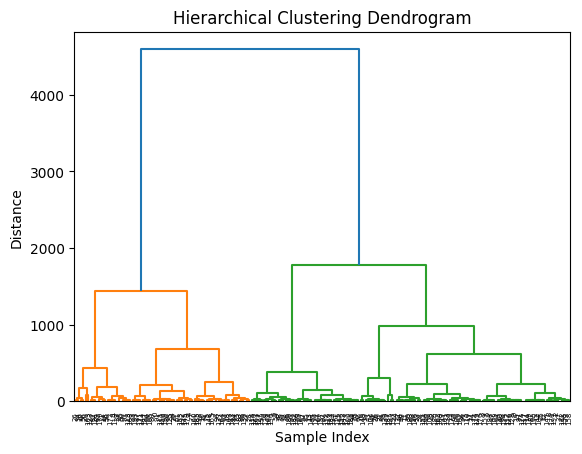

In [15]:
def extract_lat_lon(location_str):
    lat, lon = location_str.strip("()").split(", ")
    return float(lat), float(lon)

df2[['Cust_Lat', 'Cust_Lon']] = df2['Customer_Location'].apply(lambda x: pd.Series(extract_lat_lon(x)))
df2[['Rest_Lat', 'Rest_Lon']] = df2['Restaurant_Location'].apply(lambda x: pd.Series(extract_lat_lon(x)))
features= df2.drop(columns=['Order_ID', 'Customer_Location', 'Restaurant_Location']).columns
x = df2[features]
linkage_data = linkage(x, method='ward')
dendrogram(linkage_data)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

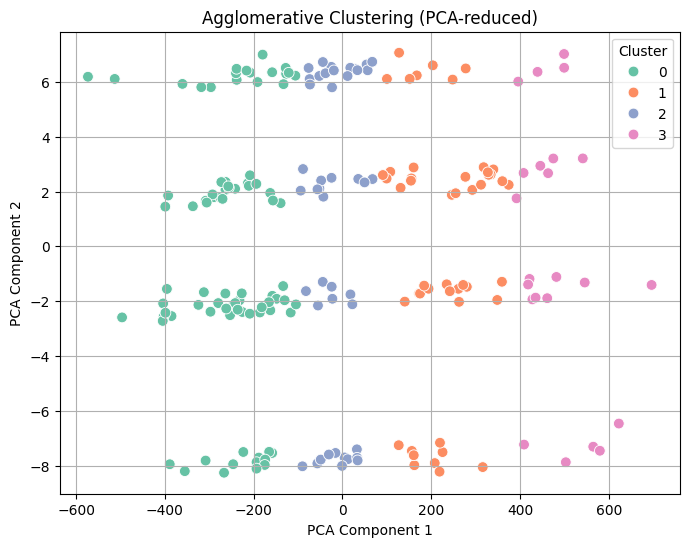

In [16]:
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
df2['Agglomerative_Cluster'] = agg_cluster.fit_predict(x)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(x)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],
                hue=df2['Agglomerative_Cluster'], palette='Set2', s=60)
plt.title('Agglomerative Clustering (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [17]:
comparison = df2[['Cluster', 'Agglomerative_Cluster']].value_counts().unstack(fill_value=0)
print(comparison)

Agglomerative_Cluster   0   1   2   3
Cluster                              
0                      26   0   0   0
1                       0  26   0  23
2                       0  22  37   0
3                      59   0   7   0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9021 - loss: 0.3959 
Test Accuracy: 0.90


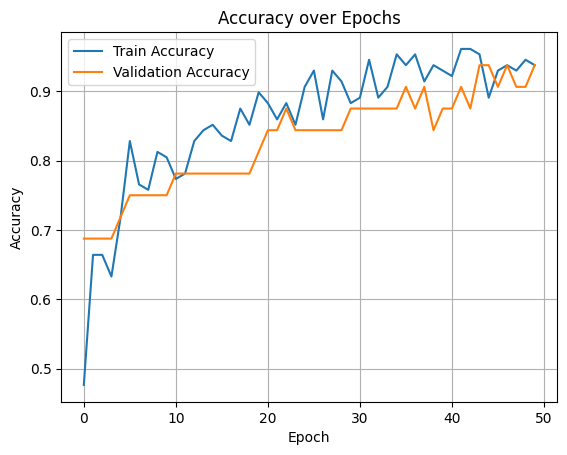

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]]               precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.88      0.88      0.88        16

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



In [30]:
import random
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

features= df2.drop(columns=['Order_ID', 'Customer_Location', 'Restaurant_Location']).columns

median_time = df2['Delivery_Time'].median()
df2['Delivery_Status'] = (df2['Delivery_Time'] > median_time).astype(int)

x= df2.drop(columns=[ 'Delivery_Status', 'Order_ID','Customer_Location','Restaurant_Location','Rest_Lat', 'Rest_Lon','Cust_Lat', 'Cust_Lon'])
y = df2['Delivery_Status']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='elu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='elu'),
    Dropout(0.2),
    Dense(16, activation='elu'),
    Dropout(0.2),
    Dense(1, activation= 'sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history= model.fit(    X_train_scaled, y_train,
    epochs=50, batch_size=16,
    validation_split=0.2,
    verbose=0)

loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {acc:.2f}")


# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

y_p=(model.predict(X_test_scaled))
y_pred = (y_p > 0.5).astype(int)
print(y_pred, end=" ")
print(classification_report(y_test, y_pred))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
model = LogisticRegression()
model.fit( X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.82      0.88      0.85        16

    accuracy                           0.88        40
   macro avg       0.87      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40



##Comparison between clustering results and neural network

Feature                    |   Clustering	    |     Neural Network
---------------------------|------------------|--------------------
Type	                     |  Unsupervised	  |       Supervised
Can predict delivery time? |	   No	          |          Yes
Interpretability	         |    High 	        |        Medium              
Accuracy (as predictor)	   |    ~60–70% 	    |        80–90%
Needs labels               |    	No	        |          Yes



##Insights from K-Means and Hierarchical Clustering
Clustering helps uncover hidden patterns in delivery data by grouping similar delivery orders based on feature similarity (e.g., distance, time, location coordinates, traffic, etc.).

Goal	                   |           Action
-------------------------|------------------------------------------------------
Faster Deliveries	       |     Predict and prioritize risky orders
Smarter Routing	         |   Use cluster zones for better path planning
Efficient Staffing	     |   Align rider resources with predicted demand
Happier Customers	       | Communicate proactively based on data-driven insights
Long-Term Optimization	 |  Track cluster patterns and refine models regularly